In [1]:
# Install Java Development Kit for Spark
!apt-get install openjdk-8-jdk

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-8-jdk is already the newest version (8u412-ga-1~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [2]:
# install PySpark with latest version
!pip install pyspark

In [3]:
# Set the JAVA_HOME env variable

import os

os.environ["JAVA_HOME"]="/usr/lib/jvm/java-8-openjdk-amd64"

In [4]:
# get current working directory
!pwd

/content


In [5]:
!echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [6]:
# mount drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# import initial libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [8]:
# Create object of spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("pyspark-ml-pipeline").getOrCreate()

In [9]:
# Read data from csv file
df = spark.read.csv("/content/bank.csv", inferSchema=True, header=True)

In [10]:
df.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

In [11]:
# Removing unwanted columns
df = df.drop(*["contact", "day", "month", "default"])
df.columns

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [12]:
df.dtypes

[('age', 'int'),
 ('job', 'string'),
 ('marital', 'string'),
 ('education', 'string'),
 ('balance', 'int'),
 ('housing', 'string'),
 ('loan', 'string'),
 ('duration', 'int'),
 ('campaign', 'int'),
 ('pdays', 'int'),
 ('previous', 'int'),
 ('poutcome', 'string'),
 ('deposit', 'string')]

In [13]:
# create a list of columns
cols = df.columns
cols

['age',
 'job',
 'marital',
 'education',
 'balance',
 'housing',
 'loan',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'deposit']

In [14]:
# get all columns that are of string datatype
categoricalCols = [item[0] for item in df.dtypes if item[1].startswith("string")]
categoricalCols

['job', 'marital', 'education', 'housing', 'loan', 'poutcome', 'deposit']

In [15]:
# get all columns that are of integer datatype
numericalCols = [item[0] for item in df.dtypes if item[1].startswith("int")]
numericalCols

['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']

In [16]:
# get basic statistics of the numerical columns
df.select(numericalCols).describe().toPandas()

,summary,age,balance,duration,campaign,pdays,previous
0,count,11162,11162,11162,11162,11162,11162
1,mean,41.231947679627304,1528.5385235620856,371.99381831213043,2.508421429851281,51.33040673714388,0.8325568894463358
2,stddev,11.913369192215518,3225.413325946149,347.12838571630687,2.7220771816614824,108.75828197197717,2.292007218670508
3,min,18,-6847,2,1,-1,0
4,max,95,81204,3881,63,854,58


In [17]:
# checking correlation between numerical columns

numerical_data = df.select(numericalCols).toPandas()
numerical_data.corr()

,age,balance,duration,campaign,pdays,previous
age,1.000000,0.112300,0.000189,-0.005278,0.002774,0.020169
balance,0.112300,1.000000,0.022436,-0.013894,0.017411,0.030805
duration,0.000189,0.022436,1.000000,-0.041557,-0.027392,-0.026716
campaign,-0.005278,-0.013894,-0.041557,1.000000,-0.102726,-0.049699
pdays,0.002774,0.017411,-0.027392,-0.102726,1.000000,0.507272
previous,0.020169,0.030805,-0.026716,-0.049699,0.507272,1.000000


In [18]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

In [19]:
stages = [] # to hold the different stages of the data transformation pipeline.

# StringIndexer: Converts categorical values into numerical indices.
# OneHotEncoder: Converts indexed values into a one-hot encoded vector.

for categoricalCol in categoricalCols:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + 'Index')
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

In [20]:
# Convert the label column (deposit) into numerical indices.

label_stringIdx = StringIndexer(inputCol='deposit', outputCol='label')
stages += [label_stringIdx]

In [21]:
# assemblerInputs: Combines the one-hot encoded vectors of the categorical columns and the numeric columns.
# VectorAssembler: Combines all feature columns into a single feature vector column named features

assemblerInputs = [c + "classVec" for c in categoricalCols] + numericalCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

In [22]:
# import pipeline
from pyspark.ml import Pipeline

# Create and set up the pipeline
pipeline = Pipeline(stages=stages)

# Fit the pipeline to the DataFrame
pipelineModel = pipeline.fit(df)

In [23]:
# Applying the fitted pipeline model to the DataFrame df to transform it
df = pipelineModel.transform(df)

# Select the columns label, features, and the original columns from cols to include in the final DataFrame.
selectedCols = ["label", "features"] + cols

# Print the schema of the transformed DataFrame to verify the structure and data types of the selected columns.
df = df.select(selectedCols)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [25]:
# check first five row instances
df.toPandas().head()

,label,features,age,job,marital,education,balance,housing,loan,duration,campaign,pdays,previous,poutcome,deposit
0,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",59,admin.,married,secondary,2343,yes,no,1042,1,-1,0,unknown,yes
1,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56,admin.,married,secondary,45,no,no,1467,1,-1,0,unknown,yes
2,1.0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",41,technician,married,secondary,1270,yes,no,1389,1,-1,0,unknown,yes
3,1.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",55,services,married,secondary,2476,yes,no,579,1,-1,0,unknown,yes
4,1.0,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",54,admin.,married,tertiary,184,no,no,673,2,-1,0,unknown,yes


In [29]:
# Splitting data to train and test set
train_df, test_df = df.randomSplit([0.8, 0.2], seed=2024)

# get length of train and test data
print("Training Dataset Count: " + str(train_df.count()))
print("Test Dataset Count: " + str(test_df.count()))

Training Dataset Count: 8953
Test Dataset Count: 2209


In [30]:
# import Logistic regression
from pyspark.ml.classification import LogisticRegression

# Initialize the Logistic Regression Model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
lrModel = lr.fit(train_df)

In [33]:
# Retrieve and Display Model Summary
lr_summary=lrModel.summary

In [35]:
# Overall accuracy of the classification model
lr_summary.accuracy

1.0

In [36]:
# Area under ROC
lr_summary.areaUnderROC

0.9999996245645324

In [37]:
# Precision of both classes
print(lr_summary.precisionByLabel)

[1.0, 1.0]


In [38]:

# Recall of both classes
print(lr_summary.recallByLabel)

[1.0, 1.0]


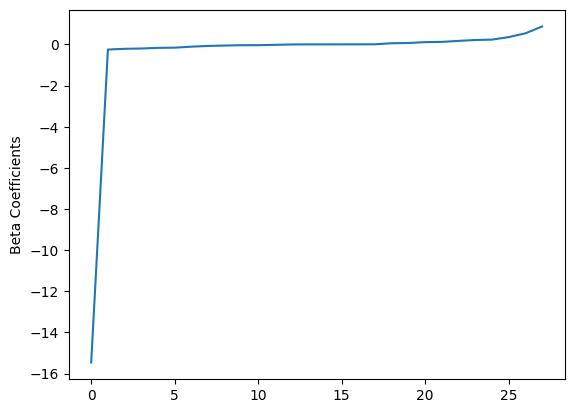

In [39]:

beta = np.sort(lrModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

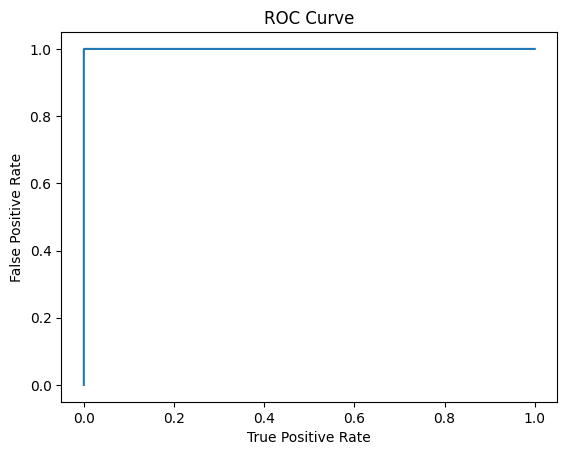

Training set areaUnderROC: 0.9999996245645324


In [40]:

trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

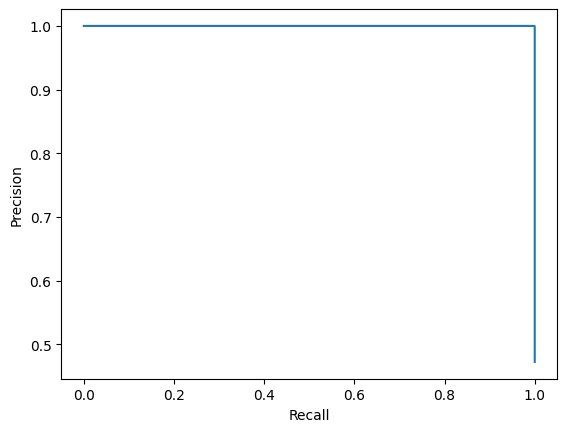

In [41]:
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [42]:
predictions = lrModel.transform(test_df)
predictions.select('label','rawPrediction','probability','prediction').toPandas().head(20)
predictions.select('label','prediction').toPandas().head(20)


,label,prediction
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
3,0.0,0.0
4,0.0,0.0
5,0.0,0.0
6,0.0,0.0
7,0.0,0.0
8,0.0,0.0
9,0.0,0.0


In [43]:
# Evaluate our Logistic Regression model.
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator()
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


In [44]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())

cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

cvModel = cv.fit(train_df)
predictions = cvModel.transform(test_df)
print('Test Area Under ROC', evaluator.evaluate(predictions))

Test Area Under ROC 1.0


In [45]:
evaluator.getMetricName()

'areaUnderROC'

In [46]:
# Decision Tree Classifier
from pyspark.ml.classification import DecisionTreeClassifier

dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
dtModel = dt.fit(train_df)

predictions = dtModel.transform(test_df)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+-------------+----------+-----------+
|age|       job|label|rawPrediction|prediction|probability|
+---+----------+-----+-------------+----------+-----------+
| 34|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 37|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 40|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 42|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 51|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 53|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 56|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 57|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 46|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
| 46|management|  0.0| [4726.0,0.0]|       0.0|  [1.0,0.0]|
+---+----------+-----+-------------+----------+-----------+
only showing top 10 rows



In [47]:
# Evaluate our Decision Tree model.
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [48]:
# Random Forest Classifier
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label')
rfModel = rf.fit(train_df)
predictions = rfModel.transform(test_df)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 34|management|  0.0|[17.2188383605564...|       0.0|[0.86094191802782...|
| 37|management|  0.0|[18.2994883449208...|       0.0|[0.91497441724604...|
| 40|management|  0.0|[16.5385086455270...|       0.0|[0.82692543227635...|
| 42|management|  0.0|[18.2994883449208...|       0.0|[0.91497441724604...|
| 51|management|  0.0|[17.4291136125581...|       0.0|[0.87145568062790...|
| 53|management|  0.0|[17.4291136125581...|       0.0|[0.87145568062790...|
| 56|management|  0.0|[18.0663458512821...|       0.0|[0.90331729256410...|
| 57|management|  0.0|[18.0663458512821...|       0.0|[0.90331729256410...|
| 46|management|  0.0|[18.2994883449208...|       0.0|[0.91497441724604...|
| 46|management|  0.0|[18.2994883449208...|       0.0|[0.91497441724604...|
+---+-------

In [49]:
# Evaluate our Decision Tree model.
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [50]:
# Gradient-Boosted Tree Classifier
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_df)
predictions = gbtModel.transform(test_df)
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 34|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 37|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 40|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 42|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 51|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 53|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 56|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 57|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 46|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
| 46|management|  0.0|[1.32590267922033...|       0.0|[0.93412217565278...|
+---+-------

In [51]:
# Evaluate our Gradient-Boosted Tree Classifier.
evaluator = BinaryClassificationEvaluator()
print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 1.0


In [52]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [53]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train_df)
predictions = cvModel.transform(test_df)

evaluator.evaluate(predictions)

1.0